In [1]:
#Data Processing
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

#XGBoost Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
#Error Metrics
from sklearn.metrics import mean_squared_error, r2_score
#HyperParameter Tuning
from sklearn.model_selection import GridSearchCV
# Perform K-Fold Cross-Validation
from sklearn.model_selection import cross_val_score
#Random Distribution
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint 
#Importance Plot
from xgboost import plot_importance


In [2]:
df = pd.read_csv("/Users/bodechiu/Desktop/Break Through Tech AI/AI Studio Project/claims_data.csv")

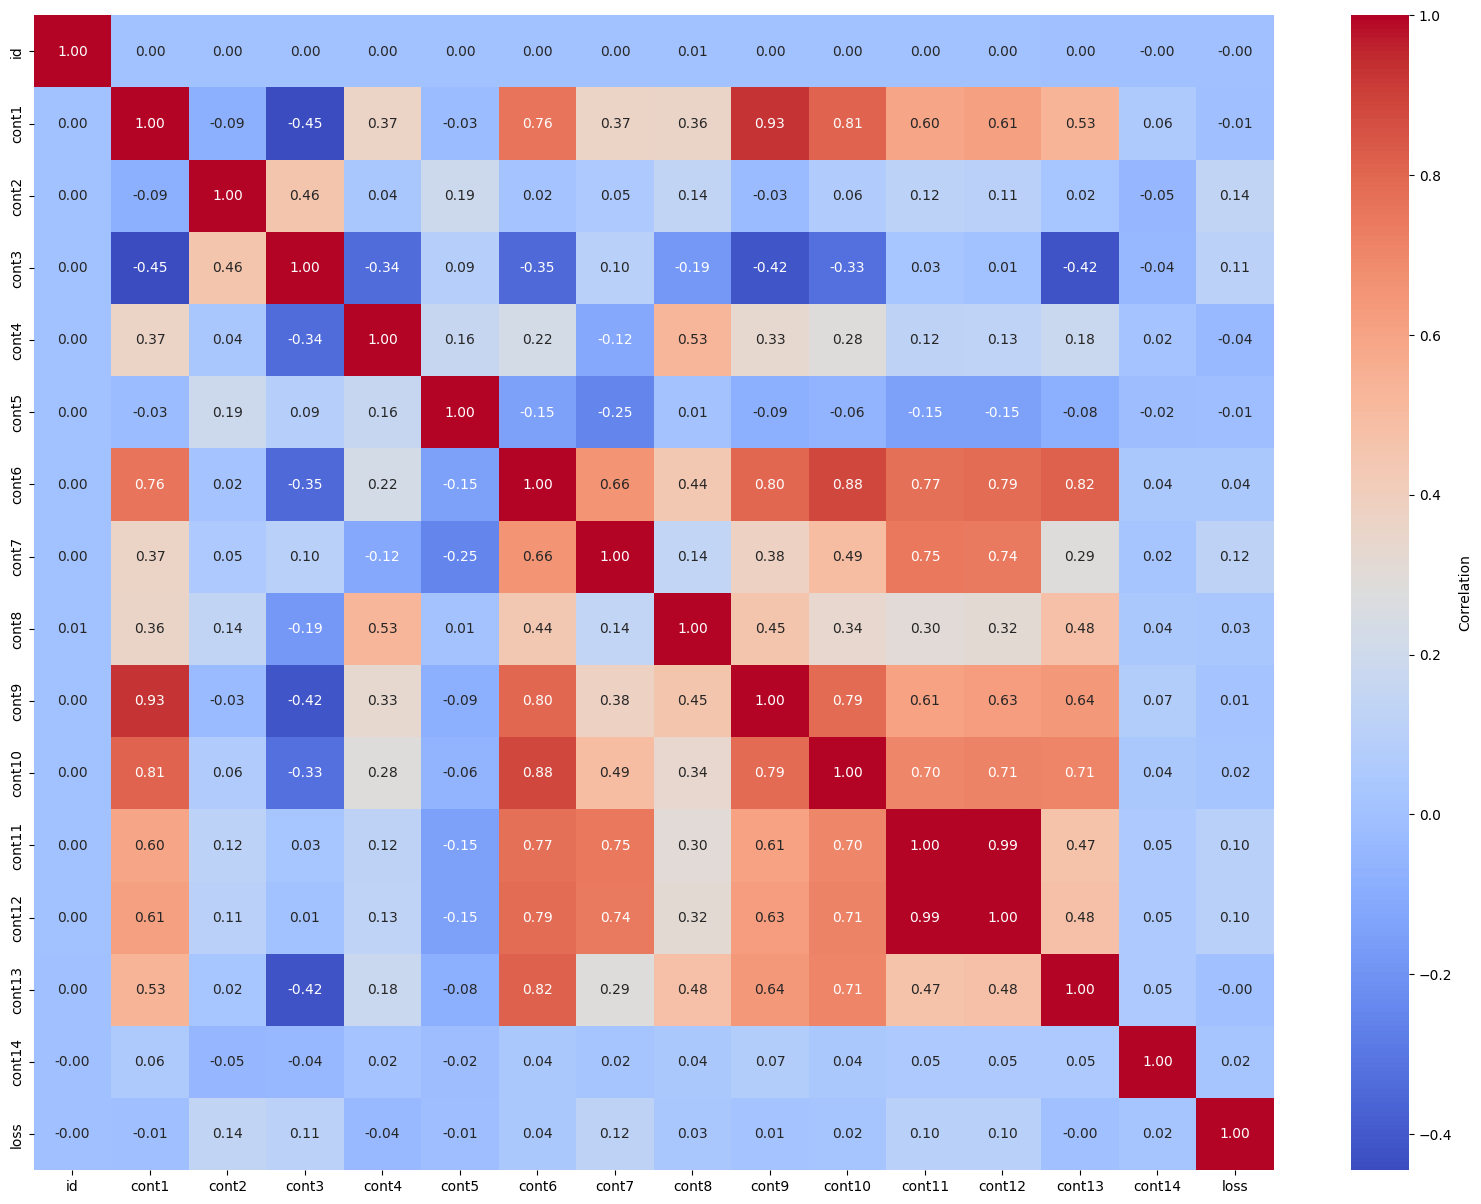

In [3]:
df_numeric = df.select_dtypes(include=[np.number])
corrMatrix = df_numeric.corr()
plt.figure(figsize=(20, 15))  # Width x Height in inches
sns.heatmap(corrMatrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10}, cbar_kws={'label': 'Correlation'})
plt.show()

<Figure size 1000x800 with 0 Axes>

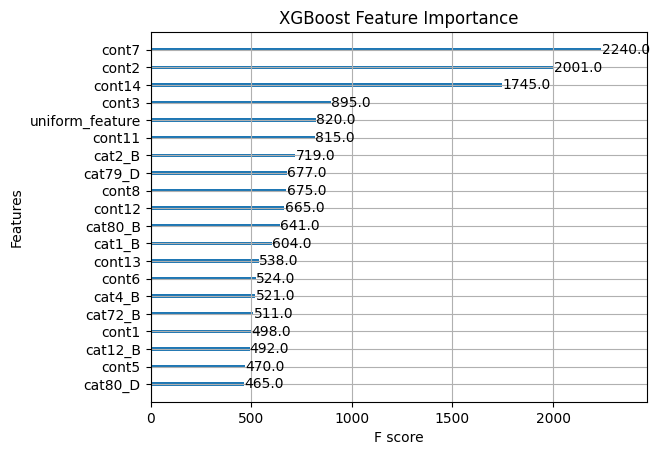

Mean Squared Error (Filtered): 3432087.742558672
Normalized Mean Squared Error: 0.4206084507157916
Root Mean Squared Error (Filtered): 1852.5894695152167
R² (Filtered): 0.5793803816010521
Data points with good predictions:
        cat1_B  cat2_B  cat4_B  cat5_B  cat6_B  cat7_B  cat9_B  cat10_B  \
10168      0.0     1.0     1.0     0.0     0.0     0.0     1.0      0.0   
6936       0.0     0.0     0.0     0.0     1.0     0.0     0.0      0.0   
117312     1.0     1.0     0.0     0.0     0.0     0.0     1.0      0.0   
70551      0.0     0.0     0.0     1.0     0.0     0.0     0.0      0.0   
97059      0.0     0.0     1.0     0.0     0.0     0.0     0.0      0.0   
...        ...     ...     ...     ...     ...     ...     ...      ...   
88497      1.0     0.0     0.0     1.0     0.0     0.0     0.0      0.0   
56217      0.0     1.0     1.0     0.0     0.0     0.0     1.0      0.0   
162470     0.0     1.0     1.0     0.0     0.0     0.0     1.0      1.0   
114899     0.0     0.0     

In [30]:
# Assuming 'df' is your DataFrame
categorical_columns = [f'cat{i}' for i in range(1, 117)]
continuous_columns = [f'cont{i}' for i in range(1, 15)]
target_column = 'loss'

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(df[categorical_columns])

# Get the feature names from the encoder and organize them
# The feature names generated will include the original column and category
categories = encoder.categories_
organized_feature_names = []

for col_index, col_name in enumerate(categorical_columns):
    for cat_index, category in enumerate(categories[col_index][1:]):  # Skip the first category due to 'drop=first'
        organized_feature_names.append(f'{col_name}_{category}')

# Convert the encoded categorical data to a DataFrame with the organized feature names
encoded_df = pd.DataFrame(encoded_categorical, columns=organized_feature_names)

# Combine the continuous columns and the one-hot encoded categorical columns
X = pd.concat([encoded_df, df[continuous_columns]], axis=1)
y = df[target_column]


# Step 1: Create a new feature with uniform distribution
np.random.seed(42)  # For reproducibility
X['uniform_feature'] = np.random.uniform(0, 1, X.shape[0])  # Add a uniform feature

# Step 2: Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the model with the new feature
best_params = {
    'colsample_bytree': 0.8998609717152555,
    'learning_rate': 0.019333132642723086,
    'max_depth': 6,
    'n_estimators': 882,
    'subsample': 0.9560699842170359,
    'eval_metric': 'rmse'  # Add evaluation metric for consistency
}
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Step 4: Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=20, importance_type="weight")  # Adjust max_num_features as needed
plt.title("XGBoost Feature Importance")
plt.show()

# Extract feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
features = X.columns

# Identify threshold using the importance of the uniform feature
uniform_feature_importance = importances[features.get_loc('uniform_feature')]

# Step 5: Drop all features that fall below the value for this new feature
important_features = features[importances >= uniform_feature_importance]
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# Retrain the model with filtered features
filtered_model = xgb.XGBRegressor(**best_params)
filtered_model.fit(X_train_filtered, y_train)

# Step 6: Make predictions using the model with filtered features
y_pred_filtered = filtered_model.predict(X_test_filtered)

# Evaluate the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R²
mse_filtered = mean_squared_error(y_test, y_pred_filtered)
rmse_filtered = np.sqrt(mse_filtered)
r2_filtered = r2_score(y_test, y_pred_filtered)

# Calculate the variance of the target variable in the test set
variance = y_test.var()

# Normalize the MSE by dividing it by the variance of the target variable
normalized_mse = mse_filtered / variance

print(f"Mean Squared Error (Filtered): {mse_filtered}")
print(f"Normalized Mean Squared Error: {normalized_mse}")
print(f"Root Mean Squared Error (Filtered): {rmse_filtered}")
print(f"R² (Filtered): {r2_filtered}")


# Step 7: Look at data where the prediction is "good"
residuals = np.abs(y_test - y_pred_filtered)
threshold = residuals.mean()  # You could set a threshold based on the mean of residuals

# Display data points where residuals are below the threshold (good predictions)
good_predictions = X_test_filtered[residuals < threshold]
print("Data points with good predictions:")
print(good_predictions)

# Step 8: Look at top predictors
top_predictors = important_features[np.argsort(importances[importances >= uniform_feature_importance])[::-1]]
print("Top predictors based on filtered model:")
print(top_predictors)

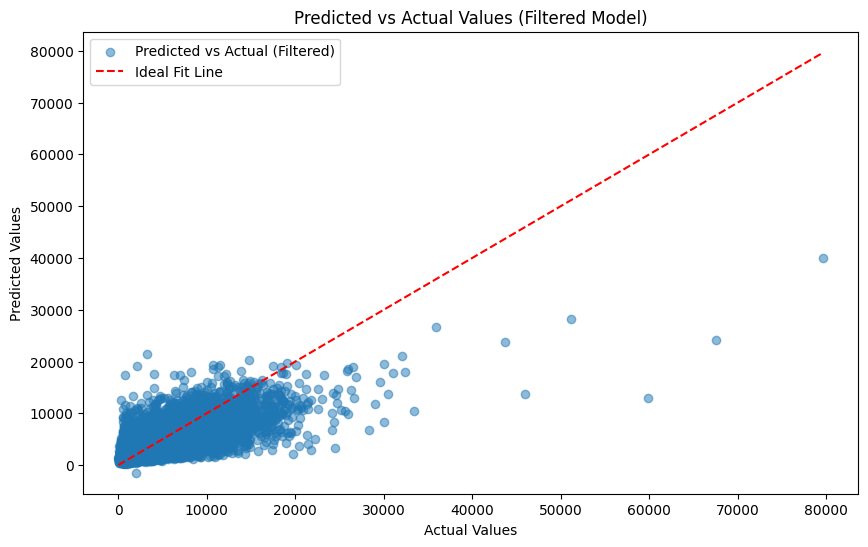

In [19]:
# Plot Predicted vs Actual values for visualization with filtered model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_filtered, alpha=0.5, label="Predicted vs Actual (Filtered)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit Line")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Filtered Model)')
plt.legend()
plt.show()

In [34]:
# Extract and print the top 20 most important features from the feature importance chart
top_20_indices = np.argsort(importances)[::-1][:50]  # Get the top 20 indices
important_features = features[top_20_indices]  # Select the top 20 features
print("Top 50 most important features:")
print(important_features)

Top 50 most important features:
Index(['cat80_D', 'cat80_B', 'cat57_B', 'cat79_D', 'cat12_B', 'cat113_U',
       'cat105_P', 'cat87_B', 'cat81_D', 'cat106_C', 'cat116_KP', 'cat107_D',
       'cat10_B', 'cont7', 'cont12', 'cat115_E', 'cont2', 'cat109_BI',
       'cat53_B', 'cat76_B', 'cat72_B', 'cat113_G', 'cat7_B', 'cat26_B',
       'cat116_J', 'cat38_B', 'cat44_B', 'cat61_B', 'cat100_I', 'cat113_AL',
       'cat11_B', 'cat82_D', 'cat1_B', 'cat13_B', 'cat100_G', 'cat113_AT',
       'cat116_U', 'cat105_T', 'cat27_B', 'cat109_AB', 'cat52_B', 'cat9_B',
       'cat49_B', 'cat108_K', 'cat116_W', 'cat115_H', 'cat91_C', 'cat79_B',
       'cat37_B', 'cat103_G'],
      dtype='object')


In [29]:
# Function to train and evaluate the model using a subset of top features
def train_and_evaluate_model(top_n):
    # Select the top 'top_n' features
    selected_features = features[indices[:top_n]]
    X_train_top = X_train[selected_features]
    X_test_top = X_test[selected_features]
    
    # Train the model with the selected features
    model_top = xgb.XGBRegressor(**best_params)
    model_top.fit(X_train_top, y_train)
    
    # Make predictions using the model with the selected features
    y_pred_top = model_top.predict(X_test_top)
    
    # Evaluate the model
    mse_top = mean_squared_error(y_test, y_pred_top)
    rmse_top = np.sqrt(mse_top)
    r2_top = r2_score(y_test, y_pred_top)
    
    print(f"Performance with top {top_n} features:")
    print(f"Mean Squared Error: {mse_top}")
    print(f"Root Mean Squared Error: {rmse_top}")
    print(f"R²: {r2_top}")
    print("\n")

# Retrain and evaluate the model with top 20, top 50, top 10, and top 5 features
train_and_evaluate_model(50)
train_and_evaluate_model(20)
train_and_evaluate_model(10)
train_and_evaluate_model(5)

Performance with top 50 features:
Mean Squared Error: 3647557.523803703
Root Mean Squared Error: 1909.8579852448986
R²: 0.5529734759616808


Performance with top 20 features:
Mean Squared Error: 4151731.997521112
Root Mean Squared Error: 2037.5799364739319
R²: 0.49118435789460924


Performance with top 10 features:
Mean Squared Error: 5036115.931649891
Root Mean Squared Error: 2244.129214561829
R²: 0.38279865776268784


Performance with top 5 features:
Mean Squared Error: 5279688.943929103
Root Mean Squared Error: 2297.7573727287013
R²: 0.35294755978324466


